_In this notebook, we assess regression algorithms on the descriptors generated by [CDK](https://cdk.github.io/)
software_.

*Briefly, we have:*
- *90 samples, 193 features, 3 tasks (LD50, melting point, boiling point);*
- *zero-valued instances (presumably unknown values);*
- *low-variance features;*
- *groups of closely related features.*

*We apply the following regression algorithms on our data:*

- *[Random Decision Forests](#Random-Decision-Forests)*
- *[Nearest Neighbors](#Nearest-Neighbors)*
- *[Kernel Ridge Regression](#Kernel-Ridge-Regression)*

*The best hyperparameters of estimators are obtained using 5-fold cross-validated*
*exhaustive search. The final model is evaluated by 3-times repeated 5-fold cross-validation.*

*For a single-task regression, we use RMSE metric.*
*For multi-task, a variance-weighted RMSE is defined as*
$$ RMSE_{w}(Y, \tilde{Y}) = \sum_{t=1}^{T}w_t RMSE(Y_{:, t}, \tilde{Y}_{:, t}),$$
$$ w_t = \frac{Var(Y_{:, t})}{\sum_{j=1}^{T}Var(Y_{:, j})}. $$

*The missing boiling and melting points are imputed with the rcv predictions*
*made by the corresponding best models.*

In [1]:
import collections
import functools
import itertools
import os
import shutil
import tempfile
import warnings

warnings.filterwarnings(action='ignore')

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

%precision 3

'%.3f'

In [4]:
from graphviz import Source

from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    IsolationForest,
    RandomForestRegressor,
)
from sklearn.feature_selection import (
    mutual_info_regression,
    SelectKBest,
    VarianceThreshold,
)
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    RepeatedKFold,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    minmax_scale,
    scale,
    MinMaxScaler,
    StandardScaler,
)
from sklearn.tree import (
    export_graphviz,
    DecisionTreeRegressor,
)

In [5]:
from nitrocomchem.featurizer import NonemptyFeatureSelector, VIFSelector
from nitrocomchem.model import RegressorChain
from nitrocomchem.transformer import YeoJohnsonTransformer
from nitrocomchem.utils import rmse_score, root_mean_squared_error

from utils import (
    RNG, KFOLD, RKFOLD,
    get_best_features,
    print_cv_scores,
    print_train_score,
    print_single_task_scores,
)

Create a cache directory to store temporary data when running grid/randomized search.

In [6]:
cachedir = tempfile.mkdtemp()
os.path.exists(cachedir)

True

Load CDK descriptors.

In [7]:
data = pd.read_csv('../data/cdk_descriptors.csv', index_col='Title')
data.head()

fragC     ATSc1     ATSc2     ATSc3     ATSc4     ATSc5      ATSm1  \
Title                                                                        
Mol1   415.03  0.057044  0.000557 -0.016223 -0.011508 -0.001291  16.908918   
Mol2   394.05  0.390286 -0.142107 -0.092427  0.070006 -0.052523  17.457856   
Mol3    74.08  0.274688  0.019850 -0.028360 -0.135178 -0.022351  20.821925   
Mol4   146.05  0.103907 -0.002558 -0.018837 -0.009499 -0.050867  20.981849   
Mol5   100.07  0.150663  0.014498 -0.014994 -0.035713 -0.063658  24.530787   

           ATSm2      ATSm3      ATSm4   ...     VAdjMat        VABC  \
Title                                    ...                           
Mol1   17.273105  22.771017  22.826914   ...    5.000000  179.717360   
Mol2   17.601473  20.099385  19.431477   ...    4.906891  164.219235   
Mol3   17.709780  25.869174  28.337902   ...    4.807355  145.183159   
Mol4   14.391058  21.006922  22.338939   ...    4.459432  133.315115   
Mol5   17.497981  25.445575  27.667306   ...    4.700440  148.259109   

          WTPT-1    WTPT-2     WTPT-3     WTPT-4    WTPT-5  WPATH  WPOL  \
Title                                                                     
Mol1   30.315799  2.021053   7.900648   4.852747  3.047901  352.0  21.0   
Mol2   27.715483  1.979677  13.670804  10.640625  3.030179  346.0  16.0   
Mol3   26.932225  1.923730  20.754652   9.650691  6.048343  287.0  21.0   
Mol4   21.235187  1.930472  12.845785   4.818938  5.521368  152.0  14.0   
Mol5   25.090584  1.930045  18.237133   9.654502  6.051643  240.0  18.0   

       Zagreb  
Title          
Mol1     74.0  
Mol2     70.0  
Mol3     68.0  
Mol4     52.0  
Mol5     62.0  

[5 rows x 193 columns]

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, Mol1 to Mol90
Columns: 193 entries, fragC to Zagreb
dtypes: float64(93), int64(100)
memory usage: 136.4+ KB


Calculate a pair-wise PCC matrix.

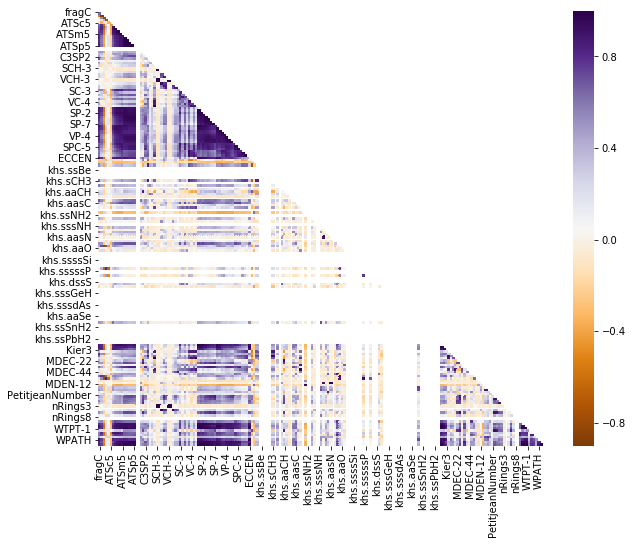

In [9]:
plt.figure(figsize=(10, 8))

corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, cmap='PuOr')
plt.show()

*Many features are highly-correlated to each other. Then it might be beneficial to select
the most informative ones depending on the mutual information scores they provide.
Additionally, when model ensembling, applying random subspace method will reduce the correlation.*

In [10]:
tasks = pd.read_csv('../data/nitrocom_tasks.csv')
tasks.head()

smiles  Log(LD50)  MeltingPoint  \
0  [H]C1=C([H])C([H])=C(C([H])=C1[H])C1=C([H])C([...      2.209          37.2   
1  [H]C1=C([H])C(=C([H])C([H])=C1OC([H])([H])C1([...      1.591          54.5   
2  [H]C1=C(F)C(=C([H])C(=C1F)[N+]([O-])=O)[N+]([O...      3.611          73.0   
3  [H]N([H])C1=C([H])C([H])=C(C([H])=C1Cl)[N+]([O...      1.429         108.0   
4  [H]C1=C([H])C(=C([H])C(=C1Cl)[N+]([O-])=O)[N+]...      2.500          43.0   

   RefractiveIndex    LD50  BoilingPoint  FlashPoint  
0           1.6050  1230.0         325.0       151.2  
1           1.5780  5000.0         351.8       177.2  
2           1.5600    50.0         306.8       139.4  
3           1.6460  6430.0         326.2       151.1  
4           1.5857   640.0         315.0       140.5

In [11]:
data.set_index(tasks.index, inplace=True)

ld50 = tasks['Log(LD50)'].copy()
bp = tasks['BoilingPoint'].copy()
mp = tasks['MeltingPoint'].copy()

---

### Random Decision Forests

Learning almost every algorithm on our data entails overfitting.
One can beat this applying ensembling techniques like bagging and random subspace method.
Our aim is to evaluate forests of decision trees using
[`RandomForestRegressor`](https://scikit-learn.org/0.19/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

Before evaluation, we filter out features with low variance. Of course, we use cross-validated
hyperparameter search to adjust the variance threshold.
In addition, the following hyperparameters are optimized:

- splitting criterion;
- number of features to consider;
- minimum number of samples in a leaf;
- maximum depth of a tree;
- bootstrap;
- impurity decrease threshold.

First, evaluate single-task random forest model on __LD50__.

In [12]:
ld50_rf_pipe = Pipeline(
    steps=[
        ('vt', VarianceThreshold(0.85 * 0.15)),
        ('rf', RandomForestRegressor(
             n_estimators=500,
             n_jobs=-1,
             random_state=RNG,
             max_depth=5,
             bootstrap=True,
         )),
    ],
    memory=cachedir
)

print_train_score(ld50_rf_pipe, data, ld50)
print_cv_scores(ld50_rf_pipe, data, ld50)

[RandomForestRegressor] Train score (RMSE): -0.308
[RandomForestRegressor] Mean cv score (RMSE): -0.678 (+/-0.151)


*For now, log transformation on LD50 produces more stable results.*

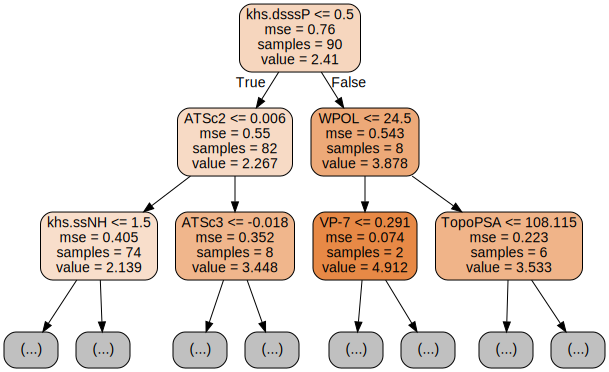

In [13]:
ld50_tree = DecisionTreeRegressor(random_state=RNG)
ld50_tree.fit(data, ld50)

tree_source = Source(export_graphviz(
    ld50_tree,
    out_file=None,
    max_depth=2,
    feature_names=data.columns,
    filled=True,
    leaves_parallel=True,
    impurity=True,
    rounded=True,
    special_characters=False,
))
tree_source

In [14]:
ld50_param_grid = {
    'vt__threshold': (0., 0.75 * 0.25, 0.85 * 0.15),
    'rf__criterion': ('mse', 'mae'),
    'rf__max_depth': (5, None),
    'rf__max_features': range(10, 35),
    'rf__min_samples_leaf': range(2, 5),
    'rf__bootstrap': (False, True),
    'rf__min_impurity_decrease': (0., 0.01, 0.1),
}
ld50_grid = GridSearchCV(
    estimator=ld50_rf_pipe,
    param_grid=ld50_param_grid,
    cv=KFOLD,
    scoring=root_mean_squared_error,
    return_train_score=False,
    n_jobs=-1,
    verbose=1,
)
# ld50_grid.fit(data, ld50)

Setting the best values of the hyperparameters, get repeated cross-validation results.

In [15]:
ld50_rf_pipe.set_params(
    vt__threshold=0.,
    rf__criterion='mse',
    rf__max_depth=None,
    rf__max_features=27,
    rf__min_samples_leaf=2,
    rf__bootstrap=False,
    rf__min_impurity_decrease=0.01,
)

print_cv_scores(ld50_rf_pipe, data, ld50)

[RandomForestRegressor] Mean cv score (RMSE): -0.680 (+/-0.125)


Our anomaly analysis with
[`IsolationForest`](https://scikit-learn.org/0.19/modules/generated/sklearn.ensemble.IsolationForest.html)
demonstrated no evidence of anomalous objects
(see `anomaly_detection.ipynb`).
Still, let's learn an isolation forest, get anomaly scores, and assign them to the sample
weights of the best random forest. We seek to emphasize the significance of inliers
and reduce the relevance of outliers.

In [16]:
isolation_forest = IsolationForest(
    n_estimators=1000,
    max_samples=0.6,
    max_features=9,
    contamination=0.1,
    bootstrap=False,
    n_jobs=-1,
    random_state=RNG,
)
sample_weights = isolation_forest.fit(data).decision_function(data)
sample_weights = minmax_scale(sample_weights.reshape(-1, 1)).ravel()

print_cv_scores(ld50_rf_pipe.named_steps['rf'], data, ld50,
                fit_params={'sample_weight': sample_weights})

[RandomForestRegressor] Mean cv score (RMSE): -0.678 (+/-0.124)


*The score remains nearly the same.*

Next, evaluate single-task random forest model on __BoilingPoint__.

In [17]:
bp_rf_pipe = clone(ld50_rf_pipe)

bp_null_idx_mask = bp.isnull()
bp_idx_mask = ~bp_null_idx_mask

print_cv_scores(bp_rf_pipe, data[bp_idx_mask], bp[bp_idx_mask])

[RandomForestRegressor] Mean cv score (RMSE): -62.559 (+/-21.484)


In [18]:
bp_param_grid = {
    'vt__threshold': (0., 0.75 * 0.25, 0.85 * 0.15),
    'rf__criterion': ('mse', 'mae'),
    'rf__max_depth': (5, None),
    'rf__max_features': range(5, 20),
    'rf__min_samples_leaf': range(2, 5),
    'rf__bootstrap': (False, True),
    'rf__min_impurity_decrease': (0., 0.01),
}
bp_grid = GridSearchCV(
    estimator=bp_rf_pipe,
    param_grid=bp_param_grid,
    cv=KFOLD,
    scoring=root_mean_squared_error,
    return_train_score=False,
    n_jobs=-1,
    verbose=1,
)
# bp_grid.fit(data[bp_idx_mask], bp[bp_idx_mask])

In [19]:
bp_rf_pipe.set_params(
    vt__threshold=0.1275,
    rf__criterion='mse',
    rf__max_depth=None,
    rf__bootstrap=False,
    rf__min_samples_leaf=2,
    rf__max_features=8,
)

print_cv_scores(bp_rf_pipe, data[bp_idx_mask], bp[bp_idx_mask])

[RandomForestRegressor] Mean cv score (RMSE): -61.569 (+/-19.701)


Next, evaluate single-task random forest model on __MeltingPoint__.

In [20]:
mp_rf_pipe = clone(bp_rf_pipe)

mp_null_idx_mask = mp.isnull()
mp_idx_mask = ~mp_null_idx_mask

print_train_score(mp_rf_pipe, data[mp_idx_mask], mp[mp_idx_mask])
print_cv_scores(mp_rf_pipe, data[mp_idx_mask], mp[mp_idx_mask])

[RandomForestRegressor] Train score (RMSE): -10.426
[RandomForestRegressor] Mean cv score (RMSE): -53.377 (+/-12.343)


In [21]:
mp_param_grid = {
    'rf__criterion': ('mse', 'mae'),
    'rf__max_depth': (5, None),
    'rf__max_features': range(7, 20),
    'rf__min_samples_leaf': (2, 3),
    'rf__bootstrap': (False, True),
}
mp_grid = GridSearchCV(
    estimator=mp_rf_pipe,
    param_grid=mp_param_grid,
    cv=KFOLD,
    scoring=root_mean_squared_error,
    return_train_score=False,
    n_jobs=-1,
    verbose=1
)
# mp_grid.fit(data[mp_idx_mask], mp[mp_idx_mask])

In [22]:
mp_rf_pipe.set_params(
    vt__threshold=0.,
    rf__criterion='mse',
    rf__max_depth=None,
    rf__min_samples_leaf=2,
    rf__max_features=17,
    rf__bootstrap=False,
)

print_cv_scores(mp_rf_pipe, data[mp_idx_mask], mp[mp_idx_mask])

[RandomForestRegressor] Mean cv score (RMSE): -51.747 (+/-12.979)


Finally, build and evaluate a multi-task random forest regressor.
Fill empty labels with repeated cross-validated predictions of the corresponding models.

In [23]:
bp_preds = []
for train_idx, _ in RKFOLD.split(data):
    idx = bp[train_idx].dropna().index
    bp_rf_pipe.fit(data.iloc[idx], bp.iloc[idx])
    bp_preds.append(bp_rf_pipe.predict(data[bp_null_idx_mask]))
bp[bp_null_idx_mask] = np.asarray(bp_preds).mean(axis=0)

mp_preds = []
for train_idx, _ in RKFOLD.split(data):
    idx = mp[train_idx].dropna().index
    mp_rf_pipe.fit(data.iloc[idx], mp.iloc[idx])
    mp_preds.append(mp_rf_pipe.predict(data[mp_null_idx_mask]))
mp[mp_null_idx_mask] = np.asarray(mp_preds).mean(axis=0)

In [24]:
targets = np.column_stack([ld50, bp, mp])

rf_pipe = Pipeline(
    steps=[
        ('vt', VarianceThreshold()),
        ('rf', RandomForestRegressor(
             n_estimators=500,
             criterion='mse',
             max_depth=None,
             min_samples_leaf=2,
             bootstrap=False,
             max_features=20,
             random_state=RNG,
             n_jobs=-1,
         )),
    ],
    memory=cachedir
)

print_train_score(rf_pipe, data, targets)
print_cv_scores(rf_pipe, data, targets)

[RandomForestRegressor] Train score (RMSE): -16.492
[RandomForestRegressor] Mean cv score (RMSE): -59.948 (+/-11.844)


In [25]:
rf_param_grid = {
    'vt__threshold': (0., 0.09),
    'rf__criterion': ('mse', 'mae'),
    'rf__max_features': range(7, 30),
    'rf__bootstrap': (False, True),
    'rf__min_samples_leaf': (2, 3),
    'rf__min_impurity_decrease': (0., 0.01, 0.05, 0.1),
}
rf_grid = GridSearchCV(
    estimator=rf_pipe,
    param_grid=rf_param_grid,
    cv=KFOLD,
    scoring=root_mean_squared_error,
    return_train_score=False,
    n_jobs=-1,
    verbose=1
)
# rf_grid.fit(data, targets)

Best repeated cross-validation multi-task score:

In [26]:
rf_pipe.set_params(
    vt__threshold=0.95 * 0.05,
    rf__criterion='mae',
    rf__max_features=10,
    rf__bootstrap=False,
    rf__min_samples_leaf=2,
)

print_cv_scores(rf_pipe, data, targets)

[RandomForestRegressor] Mean cv score (RMSE): -57.808 (+/-11.618)


Single-task cv scores:

In [27]:
print_cv_scores(bp_rf_pipe, data, bp)
print_cv_scores(mp_rf_pipe, data, mp)

[RandomForestRegressor] Mean cv score (RMSE): -61.433 (+/-13.079)
[RandomForestRegressor] Mean cv score (RMSE): -47.687 (+/-11.302)


In [28]:
print_single_task_scores(rf_pipe, data, targets)

{LD50} Mean cv score (RMSE): 0.761 (+/-0.113)
{BoilingPoint} Mean cv score (RMSE): 58.271 (+/-15.049)
{MeltingPoint} Mean cv score (RMSE): 53.142 (+/-9.185)


*Only BoilingPoint benefits from task-wise interactions.*

Let's observe the most informative features suggested by the forest.

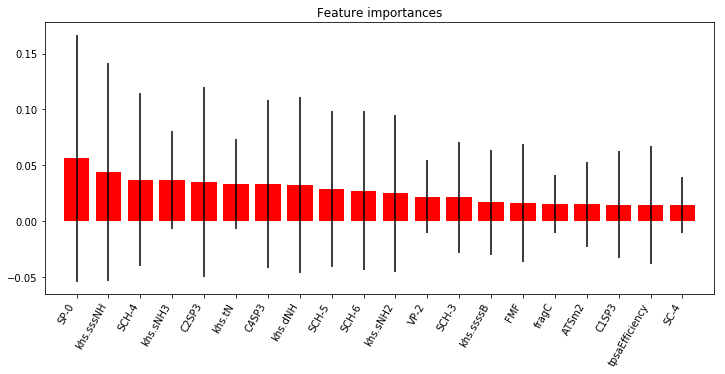

In [29]:
forest = rf_pipe.fit(data, targets).named_steps['rf']
importances = forest.feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in forest.estimators_],
    axis=0)
sorted_feat_idx = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12, 5))
plt.title('Feature importances')

plt.bar(range(sorted_feat_idx.shape[0]),
        importances[sorted_feat_idx],
        yerr=std[sorted_feat_idx],
        color='r', align='center')

plt.xticks(range(sorted_feat_idx.shape[0]),
           data.columns[sorted_feat_idx],
           rotation=60, ha='right')
plt.xlim([-1, sorted_feat_idx.shape[0]])
plt.show()

---

### Nearest Neighbors

In this subsection, we build our nearest neighbors baseline. The main solver is
[`KNeighborsRegressor`](https://scikit-learn.org/0.19/modules/generated/sklearn.neighbors.KNeighborsRegressor.html).

Recall that the number of features is much greater than desired. To reduce the dimension into a
reasonable number, we use 
[univariate feature selection](https://scikit-learn.org/0.19/modules/generated/sklearn.feature_selection.SelectKBest.html)
according to the nearest neighbors-based
[mutual information (MI)](https://scikit-learn.org/0.19/modules/generated/sklearn.feature_selection.mutual_info_regression.html).

Since kNN does not support multi-task learning, we create the nearest neighbors (*regressor*) *chain*
that makes predictions learning all the available features and the previous predictions. To create
a chain of models, the order of tasks should be specified, and following this order, the chain
will add a task as a new predictor.

The following hyperparameters are optimized:
- variance threshold;
- centering and scaling;
- number of features;
- number of neighbors (MI);
- number of neighbors (kNN);
- weight function;
- distance metric.

In [30]:
knn_pipe = Pipeline(
    steps=[
        ('vt', VarianceThreshold(0.95 * 0.05)),
        ('scale', StandardScaler()),
        ('kbest', SelectKBest(mutual_info_regression, 5)),
        ('knn', KNeighborsRegressor(n_jobs=-1, p=3)),
    ],
    memory=cachedir
)

print_cv_scores(knn_pipe, data, ld50)
print_cv_scores(knn_pipe, data[bp_idx_mask], bp[bp_idx_mask])
print_cv_scores(knn_pipe, data[mp_idx_mask], mp[bp_idx_mask])

[KNeighborsRegressor] Mean cv score (RMSE): -0.775 (+/-0.100)
[KNeighborsRegressor] Mean cv score (RMSE): -66.604 (+/-22.660)
[KNeighborsRegressor] Mean cv score (RMSE): -65.848 (+/-9.602)


In [31]:
knn_chain = RegressorChain(knn_pipe, order=[0, 1, 2])

print_cv_scores(knn_chain, data, targets)
print_single_task_scores(knn_chain, data, targets)

[RegressorChain] Mean cv score (RMSE): -78.359 (+/-8.666)
{LD50} Mean cv score (RMSE): 0.783 (+/-0.095)
{BoilingPoint} Mean cv score (RMSE): 67.412 (+/-11.330)
{MeltingPoint} Mean cv score (RMSE): 100.205 (+/-14.990)


*BoilingPoint seems to benefit from the additional feature.*

To find the best hyperparameters, we run an exhaustive search over all valid
parameters including the order of tasks in the chain. Thus, we will be able to
get best single-task scores as well.

In [32]:
def f_gaussian(x):
    return 1 / np.sqrt(2 * np.pi) * np.exp(-0.5 * x**2)


def kernel_gaussian(distances, bandwith=1.0):
    return f_gaussian(distances / bandwith)

In [33]:
ld50_knn_pipe = clone(knn_pipe)
ld50_param_grid = {
    'vt__threshold': (0., 0.8 * 0.2, 0.95 * 0.05),
    'scale__with_std': (False, True),
    'kbest__score_func': [
        functools.partial(mutual_info_regression,
                          n_neighbors=n, random_state=RNG)
        for n in range(3, 10)
    ],
    'kbest__k': range(5, 26),
    'knn__n_neighbors': range(3, 10),
    'knn__weights': (
        'uniform', 'distance',
        [functools.partial(kernel_gaussian, bandwith=h)
         for h in range(1, 21, 5)]
    ),
    'knn__metric': ('minkowski', 'manhattan', 'chebyshev', 'euclidean'),
}
ld50_grid = GridSearchCV(
    estimator=ld50_knn_pipe,
    param_grid=ld50_param_grid,
    scoring=root_mean_squared_error,
    cv=KFOLD,
    return_train_score=False,
    n_jobs=-1,
    verbose=1
)
# ld50_grid.fit(data, ld50)

In [34]:
ld50_knn_pipe.set_params(
    vt__threshold=0.0475,
    scale__with_mean=True,
    scale__with_std=False,
    kbest__score_func=functools.partial(
        mutual_info_regression, n_neighbors=3, random_state=RNG),
    kbest__k=15,
    knn__n_neighbors=6,
    knn__metric='minkowski',
    knn__p=2,
    knn__weights='distance',
)

print_cv_scores(ld50_knn_pipe, data, ld50)

[KNeighborsRegressor] Mean cv score (RMSE): -0.699 (+/-0.093)


In [35]:
columns = data.columns[
    ld50_knn_pipe.named_steps['vt']
    .fit(data)
    .get_support()
]

data_t = ld50_knn_pipe.named_steps['scale'].fit_transform(data[columns])
data_t.shape

(90, 98)

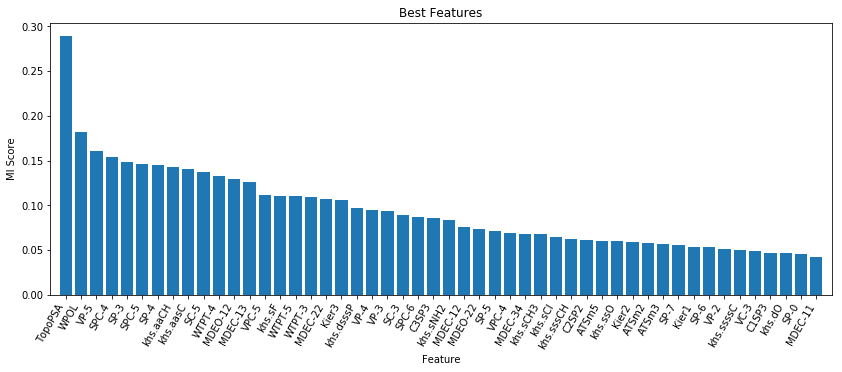

In [36]:
best_features = {}
best_features['ld50'] = get_best_features(
    ld50_knn_pipe, pd.DataFrame(data_t, columns=columns), ld50, 50)

In [37]:
bp_knn_pipe = clone(knn_pipe)
bp_param_grid = {
    'vt__threshold': (0., 0.8 * 0.2, 0.95 * 0.05),
    'scale__with_std': (False, True),
    'kbest__score_func': [
        functools.partial(mutual_info_regression,
                          n_neighbors=n, random_state=RNG)
        for n in range(2, 5)
    ],
    'kbest__k': range(12, 26),
    'knn__n_neighbors': range(3, 9),
    'knn__p': (2, 2.5, 3),
}
bp_grid = GridSearchCV(
    estimator=bp_knn_pipe,
    param_grid=bp_param_grid,
    scoring=root_mean_squared_error,
    cv=KFOLD,
    return_train_score=False,
    n_jobs=-1,
    verbose=1
)
# bp_grid.fit(data[bp_idx_mask], bp[bp_idx_mask])

In [38]:
bp_knn_pipe.set_params(
    vt__threshold=0.0475,
    scale__with_std=True,
    kbest__score_func=functools.partial(
        mutual_info_regression, n_neighbors=3, random_state=RNG),
    kbest__k=15,
    knn__n_neighbors=5,
    knn__metric='euclidean',
    knn__weights=functools.partial(kernel_gaussian, bandwith=4),
)

print_cv_scores(bp_knn_pipe, data[bp_idx_mask], bp[bp_idx_mask])

[KNeighborsRegressor] Mean cv score (RMSE): -61.629 (+/-20.115)


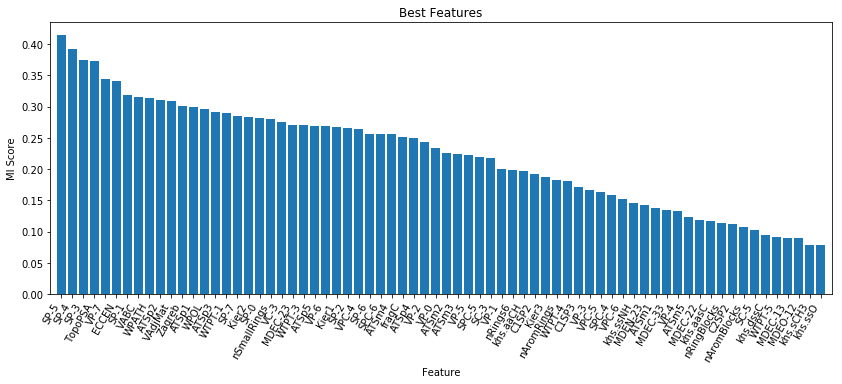

In [39]:
data_t = bp_knn_pipe.named_steps['scale'].fit_transform(
    data.loc[bp_idx_mask, columns])
data_t = pd.DataFrame(data_t, columns=columns)
best_features['bp'] = get_best_features(
    bp_knn_pipe, data_t, bp[bp_idx_mask], 70)

In [40]:
mp_knn_pipe = clone(knn_pipe)
mp_knn_pipe.set_params(
    vt__threshold=0.0475,
    scale__with_std=True,
    kbest__score_func=functools.partial(
        mutual_info_regression, n_neighbors=3, random_state=RNG),
    kbest__k=15,
    knn__n_neighbors=4,
    knn__metric='euclidean',
    knn__weights='distance',
)

print_cv_scores(mp_knn_pipe, data[mp_idx_mask], mp[mp_idx_mask])

[KNeighborsRegressor] Mean cv score (RMSE): -52.631 (+/-12.120)


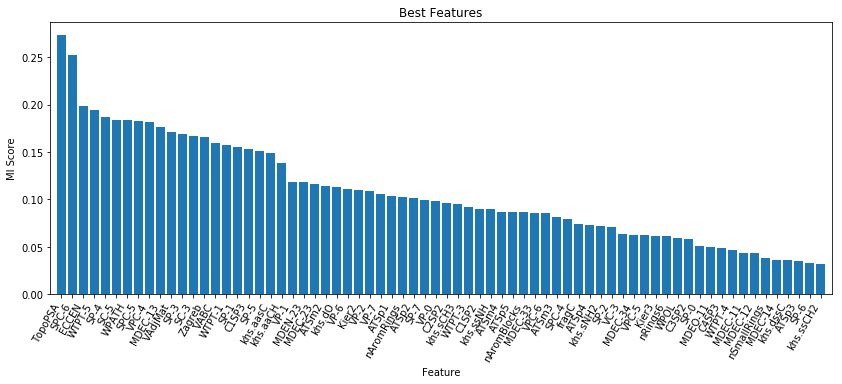

In [41]:
data_t = mp_knn_pipe.named_steps['scale'].fit_transform(
    data.loc[mp_idx_mask, columns])
data_t = pd.DataFrame(data_t, columns=columns)
best_features['mp'] = get_best_features(
    mp_knn_pipe, data_t, mp[mp_idx_mask], 70)

Impute missing labels with cv predictions and get single-task cv scores.

In [42]:
bp_preds = []
for train_idx, _ in RKFOLD.split(data):
    idx = bp[train_idx].dropna().index
    bp_knn_pipe.fit(data.iloc[idx], bp.iloc[idx])
    bp_preds.append(bp_knn_pipe.predict(data[bp_null_idx_mask]))
bp[bp_null_idx_mask] = np.asarray(bp_preds).mean(axis=0)

mp_preds = []
for train_idx, _ in RKFOLD.split(data):
    idx = mp[train_idx].dropna().index
    mp_knn_pipe.fit(data.iloc[idx], mp.iloc[idx])
    mp_preds.append(mp_knn_pipe.predict(data[mp_null_idx_mask]))
mp[mp_null_idx_mask] = np.asarray(mp_preds).mean(axis=0)

knn_targets = np.column_stack([ld50, bp, mp])

In [43]:
print_cv_scores(bp_knn_pipe, data, bp)
print_cv_scores(mp_knn_pipe, data, mp)

[KNeighborsRegressor] Mean cv score (RMSE): -66.085 (+/-15.582)
[KNeighborsRegressor] Mean cv score (RMSE): -55.335 (+/-11.081)


Now we have information about the groups of the best features preferred by 3 nearest neighbors pipelines.
The plots above indicate that every pipeline chooses quite a different set ordering. Nevertheless, they
have common preferences (TopopPSA, SPC-5, etc.), and we expect the union of the best features to share
the essential information. Important to note that our models are not effective in high dimensional spaces,
so the preferred way to combine the features is PCA.

In [44]:
best_features_set = set()
for feature_list in best_features.values():
    for feature in feature_list:
        best_features_set.add(feature)

print('Number of union of best features:', len(best_features_set))

Number of union of best features: 87


Next, varying the number of components, get total percentage of explained variance.

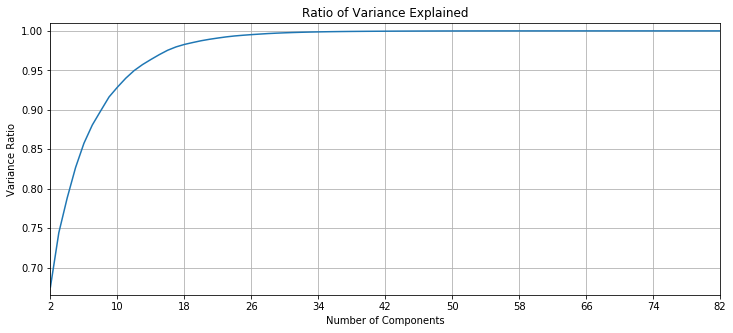

In [45]:
data_t = scale(data[list(best_features_set)])

variance_ratios = []
pca = PCA(whiten=False, svd_solver='full')
for n_components in range(2, len(best_features_set)):
    pca.n_components = n_components
    pca.fit(data_t)

    variance_ratios.append(pca.explained_variance_ratio_.sum())

plt.figure(figsize=(12, 5))
plt.title('Ratio of Variance Explained')

plt.plot(range(2, len(best_features_set)), variance_ratios)

plt.xlim([2, 82])
plt.ylim(min(variance_ratios) - 0.01, 1.01)
plt.xticks(range(2, 83, 8))
plt.xlabel('Number of Components')
plt.ylabel('Variance Ratio')
plt.grid()
plt.show()

*For the maximum efficiency, 13 to 20 components must be enough.*

Now evaluate single-task PCA-kNN scores.

In [46]:
pca.n_components = 15
data_pca = pca.fit_transform(data_t)
ld50_knn = ld50_knn_pipe.named_steps['knn']

print_cv_scores(ld50_knn, data_pca, ld50)

[KNeighborsRegressor] Mean cv score (RMSE): -0.710 (+/-0.123)


In [47]:
pca.n_components = 16
data_pca = pca.fit_transform(data_t)
bp_knn = bp_knn_pipe.named_steps['knn']

print_cv_scores(bp_knn, data_pca, bp)

[KNeighborsRegressor] Mean cv score (RMSE): -55.574 (+/-16.372)


In [49]:
pca.n_components = 15
data_pca = pca.fit_transform(data_t)
mp_knn = mp_knn_pipe.named_steps['knn']

print_cv_scores(mp_knn, data_pca, mp)

[KNeighborsRegressor] Mean cv score (RMSE): -51.603 (+/-11.379)


*PCA transformations significantly boosted cv scores on BoilingPoint.*
*MeltingPoint cv scores are also slightly improved.*
*LD50 cv scores are degraded.*

It remains to find the best task ordering in chain so as to minimize the vwRMSE objective.

In [50]:
knn_chain = RegressorChain(KNeighborsRegressor(weights='distance', n_jobs=-1))
knn_chain_pipe = Pipeline(
    steps=[
        ('pca', pca),
        ('chain', knn_chain),
    ],
    memory=cachedir
)
param_grid = {
    'pca__n_components': range(13, 26),
    'chain__base_estimator__n_neighbors': range(4, 8),
    'chain__order': list(map(list, itertools.permutations(range(3)))),
    'chain__transformer': (StandardScaler(), None),
}
knn_chain_grid = GridSearchCV(
    estimator=knn_chain_pipe,
    param_grid=param_grid,
    scoring=root_mean_squared_error,
    n_jobs=-1,
    cv=RKFOLD,
    return_train_score=False,
    verbose=1,
)
# knn_chain_grid.fit(data_t, knn_targets)

In [51]:
knn_chain_pipe.set_params(
    pca__n_components=16,
    chain__base_estimator__n_neighbors=4,
    chain__order=[1, 0, 2],
    chain__transformer=StandardScaler(),
)

print_cv_scores(knn_chain_pipe, data_t, knn_targets)
print_single_task_scores(knn_chain_pipe, pd.DataFrame(data_t), knn_targets)

[RegressorChain] Mean cv score (RMSE): -56.554 (+/-14.105)
{LD50} Mean cv score (RMSE): 0.720 (+/-0.123)
{BoilingPoint} Mean cv score (RMSE): 56.665 (+/-18.559)
{MeltingPoint} Mean cv score (RMSE): 51.065 (+/-11.513)


*Well, it is empirically derived that chaining kNNs doesn't help improve the overall performance.*

---
### Kernel Ridge Regression

Finally, we combine linear assumptions with kernel trick:
[`KernelRidge`](https://scikit-learn.org/0.19/modules/generated/sklearn.kernel_ridge.KernelRidge.html)

The correlation plot at the beginning of the notebook shows the evidence of multicollinearity.
To beat this, $L_2$-regularization and VIF filtering will be combined.

The hyperparameters tuned:
- VIF threshold;
- regularization term;
- kernel coefficients.

In [52]:
alphas = [
    stats.expon(loc=0, scale=10).rvs(size=3).tolist()
    for _ in range(1000)
]
np.mean(alphas, axis=0), np.std(alphas, axis=0)

(array([10.10882815,  9.90429198,  9.73508231]),
 array([9.9151081 , 9.91278559, 9.79742424]))

In [53]:
ridge_pipe = Pipeline(
    steps=[
        ('vt', VarianceThreshold()),
        ('scale', MinMaxScaler()),
        ('vif', VIFSelector(solver_kwargs={'n_jobs': -1})),
        ('ridge', KernelRidge(kernel='poly')),
    ],
    memory=cachedir
)
ridge_param_distributions = {
    'vt__threshold': stats.expon(loc=0.04, scale=0.5),
    'vif__threshold': stats.expon(loc=3, scale=7),
    # Multivariate normal?
    'ridge__alpha': alphas,
    'ridge__gamma': stats.uniform(loc=0, scale=10),
    'ridge__degree': stats.randint(low=2, high=5),
    'ridge__coef0': stats.randint(low=1, high=10),
}
ridge_random_search = RandomizedSearchCV(
    estimator=ridge_pipe,
    param_distributions=ridge_param_distributions,
    scoring=root_mean_squared_error,
    cv=KFOLD,
    n_jobs=-1,
    random_state=RNG,
    n_iter=600,
    verbose=1,
)

# ridge_random_search.fit(data, targets)

In [54]:
ridge_pipe.set_params(
    vt__threshold=0.15,
    vif__threshold=10.0,
    ridge__alpha=[5.23, 0.2, 0.6],
    ridge__gamma=0.05,
    ridge__degree=3,
    ridge__coef0=2,
)

print_cv_scores(ridge_pipe, data, targets)
print_single_task_scores(ridge_pipe, data, targets)

[KernelRidge] Mean cv score (RMSE): -56.982 (+/-14.703)
{LD50} Mean cv score (RMSE): 0.793 (+/-0.146)
{BoilingPoint} Mean cv score (RMSE): 58.049 (+/-20.011)
{MeltingPoint} Mean cv score (RMSE): 52.200 (+/-13.547)


*Very unstable, but good in average.*

In [57]:
ridge_pipe.set_params(
    vt__threshold=0.15,
    vif__threshold=10.0,
    ridge__alpha=0.9,
    ridge__gamma=0.05,
    ridge__degree=3,
    ridge__coef0=2,
)

ridge_chain = RegressorChain(
    ridge_pipe,
    order=[1, 2, 0],
    transformer=StandardScaler()
)

print_cv_scores(ridge_chain, data, targets)
print_single_task_scores(ridge_chain, data, targets)

[RegressorChain] Mean cv score (RMSE): -58.395 (+/-13.663)
{LD50} Mean cv score (RMSE): 0.789 (+/-0.160)
{BoilingPoint} Mean cv score (RMSE): 59.715 (+/-18.220)
{MeltingPoint} Mean cv score (RMSE): 52.540 (+/-12.688)


---
In conclusion, every evaluated model, regardless of parameter specifications, indicates that
the data is extremely lacking. Many results are unstable and even the best models are inapplicable
(although it is up to domain researchers to make final decisions about utilizing the results).
However, given adequate and informative descriptors, the algorithms __will__ learn even with low data
and the best way to obtain reasonable results is to introduce more diversity. For now, the individual
nearest-neighbors models are more advantageous to deploy.

In [77]:
shutil.rmtree(cachedir)
os.path.exists(cachedir)

False

*Notes: See the main script `run.py` from nitrocom project for more algorithm evaluations.*